In [1]:
import numpy as np
import theano
import theano.tensor as T
import matplotlib.pyplot as plt

In [2]:
from util import init_weight, all_parity_pairs
from sklearn.utils import shuffle

('i:', 0, 'j:', 0, 'nb:', 205, 'cost:', array(0.6933482580844724), 'error rate:', 0.55000000000000004)
('i:', 0, 'j:', 10, 'nb:', 205, 'cost:', array(0.6919055204703697), 'error rate:', 0.5)
('i:', 0, 'j:', 20, 'nb:', 205, 'cost:', array(0.690982568113242), 'error rate:', 0.55000000000000004)
('i:', 0, 'j:', 30, 'nb:', 205, 'cost:', array(0.6915473265495543), 'error rate:', 0.40000000000000002)
('i:', 0, 'j:', 40, 'nb:', 205, 'cost:', array(0.6991184358951819), 'error rate:', 0.69999999999999996)
('i:', 0, 'j:', 50, 'nb:', 205, 'cost:', array(0.7102415840149331), 'error rate:', 0.80000000000000004)
('i:', 0, 'j:', 60, 'nb:', 205, 'cost:', array(0.6953771368683324), 'error rate:', 0.55000000000000004)
('i:', 0, 'j:', 70, 'nb:', 205, 'cost:', array(0.6891245043102491), 'error rate:', 0.45000000000000001)
('i:', 0, 'j:', 80, 'nb:', 205, 'cost:', array(0.6914597671660664), 'error rate:', 0.45000000000000001)
('i:', 0, 'j:', 90, 'nb:', 205, 'cost:', array(0.6974251416398877), 'error rate:',

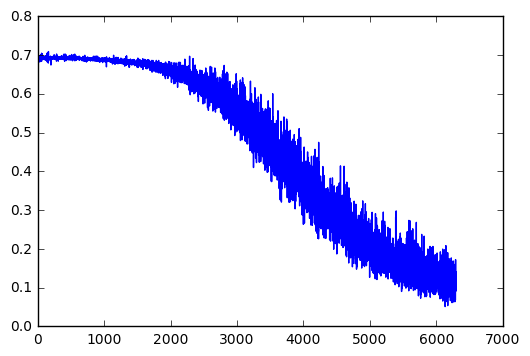

In [7]:
class hiddenLayer:
    
    def __init__(self, M1, M2, an_id):
        self.id = an_id
        self.M1 = M1
        self.M2 = M2
        W = init_weight(M1, M2)
        b = np.zeros(M2)
        self.W = theano.shared(W, 'W_%s' % self.id)
        self.b = theano.shared(b, 'b_%s' % self.id)
        self.params = [self.W, self.b]

    def forward(self, X):
        return T.nnet.relu(X.dot(self.W) + self.b)
    
class ANN(object):
    
    def __init__(self, hidden_layer_sizes):
        self.hidden_layer_sizes = hidden_layer_sizes
        
    def fit(self, X, y, learning_rate=10e-3, mu = 0.99, reg = 10e-12, epochs = 400, batch_sz = 20, print_period=1, show_fig = False):
        y = y.astype(np.int32)
        N, D = X.shape
        K = len(set(y))
        self.hidden_layers = []
        M1 = D
        count = 0
        for M2 in self.hidden_layer_sizes:
            h = hiddenLayer(M1, M2, count)
            self.hidden_layers.append(h)
            M1 = M2
            count += 1
        W = init_weight(M1, K)
        b = np.zeros(K)
        self.W = theano.shared(W, 'W_logreg')
        self.b = theano.shared(b, 'b_logreg')
        self.params = [self.W, self.b]
        
        
        for h in self.hidden_layers:
            self.params += h.params
            
        dparams = [theano.shared(np.zeros(p.get_value().shape)) for p in self.params]
        
        thX = T.matrix('X')
        thY = T.ivector('y')
        pY = self.forward(thX)
        
        rcost = reg*T.sum([(p*p).sum() for p in self.params])
        cost = -T.mean(T.log(pY[T.arange(thY.shape[0]), thY])) + rcost
        prediction = self.predict(thX)
        grads = T.grad(cost, self.params)
        
        updates = [
               (p, p + mu*dp - learning_rate*g) for p, dp, g in zip(self.params, dparams, grads)
        ]  + [
            (dp, mu*dp - learning_rate*g) for dp, g in zip(dparams, grads)
        ]
        
        train_op = theano.function(
        inputs = [thX, thY],
        outputs = [cost, prediction],
        updates = updates
        )
        
        n_batches = N /batch_sz
        cost = []
        for i in range(epochs):
            X, y = shuffle(X, y)
            for j in range(n_batches):
                Xbatch = X[j*batch_sz:(j*batch_sz + batch_sz)]
                Ybatch = y[j*batch_sz:(j*batch_sz + batch_sz)]
                
                c, p = train_op(Xbatch, Ybatch)
                
                if j % print_period == 0:
                    cost.append(c)
                    e = np.mean(Ybatch != p)
                    print("i:", i, "j:",j, "nb:", n_batches, "cost:", c, "error rate:", e)
                    
                    
        if show_fig:
           plt.plot(cost)
           plt.show()
            
    def forward(self, X):
        Z = X
        for h in self.hidden_layers:
            Z = h.forward(Z)
        return T.nnet.softmax(Z.dot(self.W) + self.b)

        
    def predict(self, X):
        pY = self.forward(X)
        return T.argmax(pY, axis=1)
        
def wide():
    X, y = all_parity_pairs(12)
    model = ANN([2048])
    model.fit(X, y, learning_rate=10e-5, print_period=10, epochs = 300, show_fig=True)

def deep():
    X, y = all_parity_pairs(12)
    model = ANN([1024]*2)
    model.fit(X, y, learning_rate=10e-4, print_period=10, epochs=100, show_fig=True)
    
if __name__ == '__main__':
    wide()
    #deep()